In [1]:
# Zequn Yuan
# CS-505 - 740
# predictive_maintenance.py

# --- Section 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [2]:
# --- Section 2: Load Dataset ---
file_path = 'C:/Users/Yuan/Downloads/train_FD001.txt'
df = pd.read_csv(file_path, delim_whitespace=True, header=None)
df.columns = ['engine_id', 'cycle'] + ['op_setting1', 'op_setting2', 'op_setting3'] + [f'sensor{i}' for i in range(1, 22)]
print(df.head())
print(f"Dataset Shape: {df.shape}")

C:\Users\Yuan\AppData\Local\Temp\ipykernel_3428\3494852974.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


   engine_id  cycle  op_setting1  op_setting2  op_setting3  sensor1  sensor2  \
0          1      1      -0.0007      -0.0004        100.0   518.67   641.82   
1          1      2       0.0019      -0.0003        100.0   518.67   642.15   
2          1      3      -0.0043       0.0003        100.0   518.67   642.35   
3          1      4       0.0007       0.0000        100.0   518.67   642.35   
4          1      5      -0.0019      -0.0002        100.0   518.67   642.37   

   sensor3  sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  \
0  1589.70  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195   
1  1591.82  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318   
2  1587.99  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178   
3  1582.79  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682   
4  1582.85  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294   

   sensor16  sensor17  sensor18  sensor19  sensor20  sen

In [3]:
# --- Section 3: Preprocessing ---
df['RUL'] = df.groupby('engine_id')['cycle'].transform(max) - df['cycle']
selected_sensors = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor11', 'sensor15', 'sensor20']
data = df[selected_sensors + ['RUL']]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
X = scaled_data[:, :-1]
y = (df['RUL'] < 30).astype(int)  # Binary label: failure within 30 cycles

C:\Users\Yuan\AppData\Local\Temp\ipykernel_3428\4055481635.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['RUL'] = df.groupby('engine_id')['cycle'].transform(max) - df['cycle']


In [4]:
# --- Section 4: Random Forest Classifier ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred_rf))


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3559
           1       0.84      0.77      0.80       568

    accuracy                           0.95      4127
   macro avg       0.90      0.87      0.89      4127
weighted avg       0.95      0.95      0.95      4127



In [5]:
# --- Section 5: Sequence Preparation for LSTM ---
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2)

In [6]:
# --- Section 6: LSTM Model ---
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(30, X.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=64, validation_data=(X_test_seq, y_test_seq))


Epoch 1/30


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8674 - loss: 0.3214 - val_accuracy: 0.8988 - val_loss: 0.1967
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9410 - loss: 0.1365 - val_accuracy: 0.9403 - val_loss: 0.1312
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9517 - loss: 0.1136 - val_accuracy: 0.9471 - val_loss: 0.1224
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9546 - loss: 0.1063 - val_accuracy: 0.9512 - val_loss: 0.1058
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9568 - loss: 0.0999 - val_accuracy: 0.9546 - val_loss: 0.0997
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9565 - loss: 0.0982 - val_accuracy: 0.9583 - val_loss: 0.0937
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9597 - loss: 0.0933 - val_accuracy: 0.9585 - val_loss: 0.0978
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9631 - loss: 0.0911 - val_accuracy: 0.959

In [7]:
# --- Section 7: LSTM Evaluation ---
y_pred_lstm = model.predict(X_test_seq)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)

print("\n--- LSTM Evaluation Metrics ---")
print("Accuracy:", accuracy_score(y_test_seq, y_pred_lstm_binary))
print("Precision:", precision_score(y_test_seq, y_pred_lstm_binary))
print("Recall:", recall_score(y_test_seq, y_pred_lstm_binary))
print("F1-score:", f1_score(y_test_seq, y_pred_lstm_binary))

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- LSTM Evaluation Metrics ---
Accuracy: 0.9667556418345062
Precision: 0.8586626139817629
Recall: 0.9277504105090312
F1-score: 0.8918705603788477


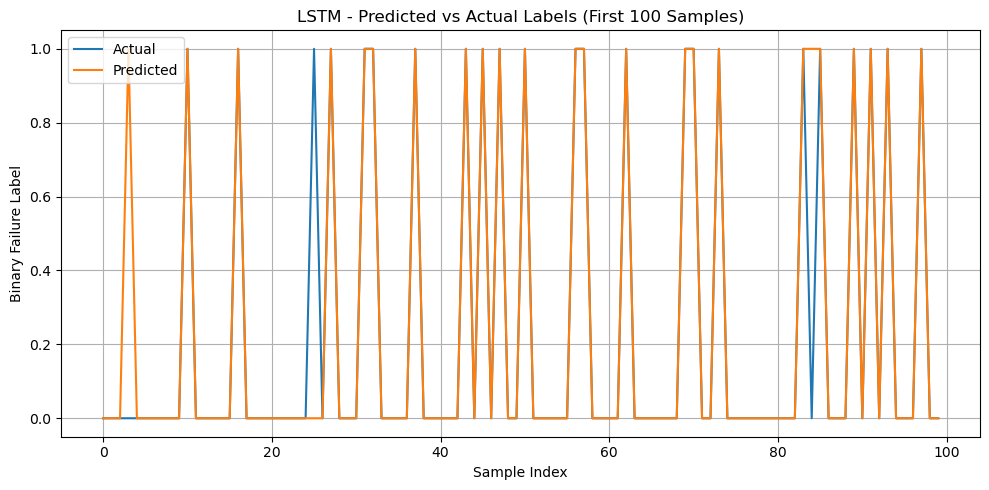

In [8]:
# --- Section 8: Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq[:100], label='Actual')
plt.plot(y_pred_lstm_binary[:100], label='Predicted')
plt.title("LSTM - Predicted vs Actual Labels (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Binary Failure Label")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Save model for reproducibility
model.save("lstm_predictive_model.h5")